# Data Processing

In [1]:
# Install if needed: pip install yfinance pandas numpy
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
#data_raw = pd.read_csv("SP500_raw.csv")
#data_raw = pd.read_csv("DAX.csv")
data_raw = pd.read_csv("FTSE100_raw.csv")
print(data_raw.columns)
print(data_raw)

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')
            Date     Price      Open      High       Low     Vol. Change %
0     12/29/2023  7,733.24  7,722.74  7,746.91  7,719.02  225.64M    0.14%
1     12/28/2023  7,722.74  7,724.95  7,745.99  7,708.74  316.82M   -0.03%
2     12/27/2023  7,724.95  7,697.51  7,759.74  7,697.51  409.46M    0.36%
3     12/22/2023  7,697.51  7,694.73  7,715.21  7,676.43  320.56M    0.04%
4     12/21/2023  7,694.73  7,715.68  7,715.68  7,668.41  562.95M   -0.27%
...          ...       ...       ...       ...       ...      ...      ...
2267  01/08/2015  6,569.96  6,419.83  6,580.82  6,419.83  910.04M    2.34%
2268  01/07/2015  6,419.83  6,366.51  6,459.74  6,366.51  709.50M    0.84%
2269  01/06/2015  6,366.51  6,417.16  6,452.66  6,328.59  793.26M   -0.79%
2270  01/05/2015  6,417.16  6,547.80  6,576.74  6,404.49  750.52M   -2.00%
2271  01/02/2015  6,547.80  6,566.09  6,607.89  6,510.60  378.93M   -0.28%

[2272 rows x 7 

In [3]:
def convert_german_float(value):
    if isinstance(value, str):
        # Remove periods (thousands separator)
        cleaned_value = value.replace('.', '')
        # Replace comma (decimal separator) with period
        cleaned_value = cleaned_value.replace(',', '.')
        try:
            return float(cleaned_value)
        except ValueError:
            return np.nan # Or handle other errors as needed
    return value # Return as is if not a string (e.g., already a number or NaN)
data_raw['Price'] = data_raw['Price'].apply(convert_german_float)

In [4]:
# -----------------------------------
# STEP 2: Clean and enrich the data
# -----------------------------------
# First compute daily log return
data_raw["LogReturn"] = np.log(data_raw["Price"].shift(1) / data_raw["Price"])

# Fit scaler on LogReturn and transform
#split_idx = int(len(data_raw) * 0.8)
#scaler = StandardScaler()
#scaler.fit(data_raw.loc[:split_idx-1, ["LogReturn"]])

# Define the prediction target: "HORIZON"-day forward cumulative return
HORIZON = 5 # cumulative return of 5 days 
cum_return = data_raw["LogReturn"].rolling(window=HORIZON).sum()

print(cum_return.head(10))
# Drop rows where cum_return is NaN before creating the Target column
mask = cum_return.notna()
data_raw = data_raw[mask].reset_index(drop=True)
cum_return = cum_return[mask].reset_index(drop=True)
data_raw["Target"] = (cum_return > 0).astype(int)

print(data_raw)

#data_raw["LogReturn"] = scaler.transform(data_raw[["LogReturn"]])

# Keep only date, log return and target
data = data_raw[["Date", "Target"]]

# Drop the first row with NaN return (from shift operation)
data.dropna(inplace=True)
print(data.head(10))
# INSERT_YOUR_CODE
target_ratio = data["Target"].mean()
print(f"Ratio of Targets (mean of Target column): {target_ratio:.4f}")


0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
5    0.002273
6    0.011030
7    0.014404
8    0.015864
9    0.005963
Name: LogReturn, dtype: float64
            Date    Price      Open      High       Low     Vol. Change %  \
0     12/20/2023  7.71568  7,638.03  7,762.88  7,637.93  875.63M    1.02%   
1     12/19/2023  7.63803  7,614.48  7,642.15  7,605.35  935.13M    0.31%   
2     12/18/2023  7.61448  7,576.36  7,630.57  7,557.24  661.07M    0.50%   
3     12/15/2023  7.57636  7,648.98  7,668.22  7,569.00    1.58B   -0.95%   
4     12/14/2023  7.64898  7,548.44  7,724.81  7,548.44    1.44B    1.33%   
...          ...      ...       ...       ...       ...      ...      ...   
2262  01/08/2015  6.56996  6,419.83  6,580.82  6,419.83  910.04M    2.34%   
2263  01/07/2015  6.41983  6,366.51  6,459.74  6,366.51  709.50M    0.84%   
2264  01/06/2015  6.36651  6,417.16  6,452.66  6,328.59  793.26M   -0.79%   
2265  01/05/2015  6.41716  6,547.80  6,576.74  6,404.49  7

/var/folders/4c/gx6ft8qx2c90jb6mwvlx3gcw0000gn/T/ipykernel_19814/797231117.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


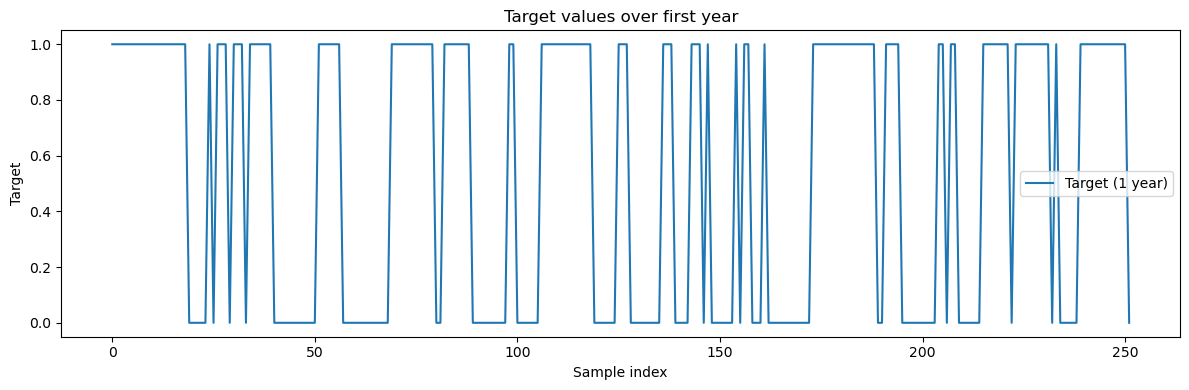

In [5]:
# INSERT_YOUR_CODE
import matplotlib.pyplot as plt

# Plot only one year of data (first 252 trading days, typical for one year)
one_year = data.head(252).copy()

plt.figure(figsize=(12, 4))
plt.plot(one_year["Target"].reset_index(drop=True), label="Target (1 year)")
plt.title("Target values over first year")
plt.xlabel("Sample index")
plt.ylabel("Target")
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
# -----------------------------------
# STEP 3: Create lag features
# -----------------------------------
N_LAGS = 5
for lag in range(1, N_LAGS + 1):
    # Compute the running average from lag-2 to lag (i.e., lags lag, lag-1, lag-2)
    # For lag < 3, use available lags only (i.e., for lag=1, just lag 1; for lag=2, lag 2 and lag 1)
    #lags = []
    #for offset in range(0, 3):
    #    lag_offset = lag + offset
    #    lags.append(data["LogReturn"].shift(-lag_offset))
    #if lags:
    #    data[f"Lag_{lag}"] = sum(lags) / len(lags)
    data[f"Lag_{lag}"] = data["Target"].shift(-lag)
# Add lagged date columns
for lag in range(1, N_LAGS + 1):
    data[f"Date_Lag_{lag}"] = data["Date"].shift(-lag)

data.dropna(inplace=True)  # drop rows with NaNs introduced by lagging

#data.drop(columns=["LogReturn"], inplace=True) # LogReturn no more needed
print(data.head(3))

         Date  Target  Lag_1  Lag_2  Lag_3  Lag_4  Lag_5  Date_Lag_1  \
0  12/20/2023       1    1.0    1.0    1.0    1.0    1.0  12/19/2023   
1  12/19/2023       1    1.0    1.0    1.0    1.0    1.0  12/18/2023   
2  12/18/2023       1    1.0    1.0    1.0    1.0    1.0  12/15/2023   

   Date_Lag_2  Date_Lag_3  Date_Lag_4  Date_Lag_5  
0  12/18/2023  12/15/2023  12/14/2023  12/13/2023  
1  12/15/2023  12/14/2023  12/13/2023  12/12/2023  
2  12/14/2023  12/13/2023  12/12/2023  12/11/2023  


/var/folders/4c/gx6ft8qx2c90jb6mwvlx3gcw0000gn/T/ipykernel_19814/557131928.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"Lag_{lag}"] = data["Target"].shift(-lag)
/var/folders/4c/gx6ft8qx2c90jb6mwvlx3gcw0000gn/T/ipykernel_19814/557131928.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"Lag_{lag}"] = data["Target"].shift(-lag)
/var/folders/4c/gx6ft8qx2c90jb6mwvlx3gcw0000gn/T/ipykernel_19814/557131928.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [7]:
# -----------------------------------
# STEP 4: Add temporal features
# -----------------------------------

# Helper to add cyclical features for a given date column
def add_cyclical_features(df, date_col, prefix):
    # Ensure the date column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col], format="%m/%d/%Y")
    
    # Extract raw features
    df[f"{prefix}_day_of_week"] = df[date_col].dt.dayofweek   # 0-6
    df[f"{prefix}_month"] = df[date_col].dt.month             # 1-12
    df[f"{prefix}_day_of_month"] = df[date_col].dt.day        # 1-31

    # Day of week: 0-6, max_value=7
    df[f"{prefix}_dow_sin"] = np.sin(2 * np.pi * df[f"{prefix}_day_of_week"] / 7)
    df[f"{prefix}_dow_cos"] = np.cos(2 * np.pi * df[f"{prefix}_day_of_week"] / 7)
    # Month: 1-12, max_value=12
    df[f"{prefix}_month_sin"] = np.sin(2 * np.pi * df[f"{prefix}_month"] / 12)
    df[f"{prefix}_month_cos"] = np.cos(2 * np.pi * df[f"{prefix}_month"] / 12)
    # Day of month: 1-31, max_value=31
    df[f"{prefix}_dom_sin"] = np.sin(2 * np.pi * df[f"{prefix}_day_of_month"] / 31)
    df[f"{prefix}_dom_cos"] = np.cos(2 * np.pi * df[f"{prefix}_day_of_month"] / 31)

# Add cyclical features for each lagged date column
for lag in range(1, N_LAGS + 1):
    lag_col = f"Date_Lag_{lag}"
    add_cyclical_features(data, lag_col, f"lag{lag}")

# Learn a scaler on the first 80% of the dataset, then apply to all sin and cos columns
full_train_size = int(len(data) * 0.8)
sin_cos_cols = [col for col in data.columns if col.endswith("_sin") or col.endswith("_cos") or col.startswith("Lag")]
scaler_cyc = StandardScaler()
scaler_cyc.fit(data.loc[:full_train_size-1, sin_cos_cols])
data[sin_cos_cols] = scaler_cyc.transform(data[sin_cos_cols])

cols_to_drop = [col for col in data.columns if col.startswith("Date_Lag_") or 
            col.endswith("_day_of_week") or col.endswith("_month") or col.endswith("_day_of_month")]
data.drop(columns=cols_to_drop, inplace=True)
print(data)

            Date  Target     Lag_1     Lag_2     Lag_3     Lag_4     Lag_5  \
0     12/20/2023       1  0.908531  0.909545  0.910560  0.910560  0.910560   
1     12/19/2023       1  0.908531  0.909545  0.910560  0.910560  0.910560   
2     12/18/2023       1  0.908531  0.909545  0.910560  0.910560  0.910560   
3     12/15/2023       1  0.908531  0.909545  0.910560  0.910560  0.910560   
4     12/14/2023       1  0.908531  0.909545  0.910560  0.910560  0.910560   
...          ...     ...       ...       ...       ...       ...       ...   
2257  01/15/2015       1  0.908531  0.909545  0.910560  0.910560 -1.098225   
2258  01/14/2015       1  0.908531  0.909545  0.910560 -1.098225 -1.098225   
2259  01/13/2015       1  0.908531  0.909545 -1.098225 -1.098225  0.910560   
2260  01/12/2015       1  0.908531 -1.099450 -1.098225  0.910560  0.910560   
2261  01/09/2015       1 -1.100678 -1.099450  0.910560  0.910560 -1.098225   

      lag1_dow_sin  lag1_dow_cos  lag1_month_sin  ...  lag4_mon

In [8]:
data.to_csv("FTSE100_classification_easy.csv", index=False)
#data.to_csv("SP500_classification_easy.csv", index=False)
#data.to_csv("DAX_classification_easy.csv", index=False)

In [ ]:
# INSERT_YOUR_CODE
for col in data.columns:
    print(f"{col}: {data.iloc[0][col]}")


In [ ]:
[ 1.8245181e-01  9.7492790e-01 -2.2252093e-01 -2.4492937e-16
  1.0000000e+00  4.8530197e-01 -8.7434661e-01]
features[1]: [-4.2922173e-02  4.3388373e-01 -9.0096885e-01 -2.4492937e-16
  1.0000000e+00  2.9936314e-01 -9.5413923e-01]
features[2]: [ 3.3777958e-01 -4.3388373e-01 -9.0096885e-01 -2.4492937e-16
  1.0000000e+00  1.0116832e-01 -9.9486935e-01]
features[3]: [ 4.4808266e-01  0.0000000e+00  1.0000000e+00 -2.4492937e-16
  1.0000000e+00 -4.8530197e-01 -8.7434661e-01]
features[4]: [-1.2623984e+00  7.8183150e-01  6.2348980e-01 -2.4492937e-16
  1.0000000e+00 -6.5137249e-01 -7.5875813e-01]
features[5]: [ 8.1263912e-01  9.7492790e-01 -2.2252093e-01 -2.4492937e-16
  1.0000000e+00 -7.9077572e-01 -6.1210597e-01]
features[6]: [ 1.00843295e-01  4.33883727e-01 -9.00968850e-01 -2.44929371e-16
  1.00000000e+00 -8.97804558e-01 -4.40394163e-01]
features[7]: [ 3.1330523e-01 -4.3388373e-01 -9.0096885e-01 -2.4492937e-16
  1.0000000e+00 -9.6807712e-01 -2.5065252e-01]
features[8]: [ 8.1843957e-02  7.8183150e-01  6.2348980e-01 -2.4492937e-16
  1.0000000e+00 -8.4864426e-01  5.2896398e-01]
features[9]: [-5.9337257e-03  9.7492790e-01 -2.2252093e-01 -2.4492937e-16
  1.0000000e+00 -7.2479278e-01  6.8896693e-01]